In [9]:
import os
import numpy as np
import torch
import gzip
import struct
from tqdm import tqdm
import torch.nn as nn
import torch.utils.data as data_utils

import torch.nn as nn
import sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
sys.path.append(os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath("__file__")))))
import custom_loaders
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import trange
from prettytable import PrettyTable
# import wandb
# import conv_layers

# from utils import count_parameters
def count_parameters(model, print_table = False):

    total_params = 0
    if(print_table):
        table = PrettyTable(["Modules", "Parameters"])

    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()

        if(print_table):
            table.add_row([name, params])
        total_params += params

    if(print_table):
        print(table)

    if total_params/1e9 > 1:
        print(f"Total Trainable Params: {total_params/1e9} B")
    else:
        print(f"Total Trainable Params: {total_params/1e6} M")

    return total_params

In [10]:
# !wget https://huggingface.co/datasets/student/celebA/resolve/main/Dataset.zip?download=true
# !unzip -q Dataset.zip?download=truea

In [11]:
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz

with gzip.open('train-images-idx3-ubyte.gz','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    fmnist = np.frombuffer(f.read(), dtype=np.dtype(np.uint8).newbyteorder('>'))
    fmnist = fmnist.reshape((size, nrows, ncols))

--2024-01-01 07:29:19--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.170.224, 52.219.168.24, 52.219.170.188, ...
Connecting to fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)|52.219.170.224|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26421880 (25M) [binary/octet-stream]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]  25.20M  11.3MB/s    in 2.2s    

2024-01-01 07:29:22 (11.3 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [26421880/26421880]



In [12]:
## Time Embed

class EmbedTime(nn.Module):
    def __init__(self, input_d, time_d):
        super().__init__()
        self.ln1 = nn.Linear(input_d, time_d)
        self.ln2 = nn.Linear(time_d, time_d)
        self.relu = nn.ReLU()

    def forward(self, x):

        x = self.ln1(x)
        x = self.ln2(self.relu(x))
        return x

def sinosoid_embed(edim, t_max):
    pos_emb = torch.zeros((t_max, edim))
    for pos in range(t_max):
        for i in range(edim//2):
            pos_emb[pos, 2*i] = np.sin(pos/(10000**(2*i/edim)))
            pos_emb[pos, 2*i + 1] = np.cos(pos/(10000**(2*i/edim)))

    return pos_emb.T

In [13]:
class MyBlock(nn.Module):
    def __init__(self, shape, in_c, out_c, kernel_size=3, stride=1, padding=1, activation=None, normalize=True):
        super(MyBlock, self).__init__()
        self.ln = nn.LayerNorm(shape)
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size, stride, padding)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size, stride, padding)
        self.activation = nn.SiLU() if activation is None else activation
        self.normalize = normalize

    def forward(self, x):
        out = self.ln(x) if self.normalize else x
        out = self.conv1(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.activation(out)
        return out


class MyUNet(nn.Module):
    def __init__(self, n_steps=1000, time_emb_dim=100):
        super(MyUNet, self).__init__()

        # Sinusoidal embedding
        self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        self.time_embed.weight.data = sinosoid_embed(n_steps, time_emb_dim)
        self.time_embed.requires_grad_(False)

        # First half
        self.te1 = self._make_te(time_emb_dim, 1)
        self.b1 = nn.Sequential(
            MyBlock((1, 28, 28), 1, 10),
            MyBlock((10, 28, 28), 10, 10),
            MyBlock((10, 28, 28), 10, 10)
        )
        self.down1 = nn.Conv2d(10, 10, 4, 2, 1)

        self.te2 = self._make_te(time_emb_dim, 10)
        self.b2 = nn.Sequential(
            MyBlock((10, 14, 14), 10, 20),
            MyBlock((20, 14, 14), 20, 20),
            MyBlock((20, 14, 14), 20, 20)
        )
        self.down2 = nn.Conv2d(20, 20, 4, 2, 1)

        self.te3 = self._make_te(time_emb_dim, 20)
        self.b3 = nn.Sequential(
            MyBlock((20, 7, 7), 20, 40),
            MyBlock((40, 7, 7), 40, 40),
            MyBlock((40, 7, 7), 40, 40)
        )
        self.down3 = nn.Sequential(
            nn.Conv2d(40, 40, 2, 1),
            nn.SiLU(),
            nn.Conv2d(40, 40, 4, 2, 1)
        )

        # Bottleneck
        self.te_mid = self._make_te(time_emb_dim, 40)
        self.b_mid = nn.Sequential(
            MyBlock((40, 3, 3), 40, 20),
            MyBlock((20, 3, 3), 20, 20),
            MyBlock((20, 3, 3), 20, 40)
        )

        # Second half
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(40, 40, 4, 2, 1),
            nn.SiLU(),
            nn.ConvTranspose2d(40, 40, 2, 1)
        )

        self.te4 = self._make_te(time_emb_dim, 80)
        self.b4 = nn.Sequential(
            MyBlock((80, 7, 7), 80, 40),
            MyBlock((40, 7, 7), 40, 20),
            MyBlock((20, 7, 7), 20, 20)
        )

        self.up2 = nn.ConvTranspose2d(20, 20, 4, 2, 1)
        self.te5 = self._make_te(time_emb_dim, 40)
        self.b5 = nn.Sequential(
            MyBlock((40, 14, 14), 40, 20),
            MyBlock((20, 14, 14), 20, 10),
            MyBlock((10, 14, 14), 10, 10)
        )

        self.up3 = nn.ConvTranspose2d(10, 10, 4, 2, 1)
        self.te_out = self._make_te(time_emb_dim, 20)
        self.b_out = nn.Sequential(
            MyBlock((20, 28, 28), 20, 10),
            MyBlock((10, 28, 28), 10, 10),
            MyBlock((10, 28, 28), 10, 10, normalize=False)
        )

        self.conv_out = nn.Conv2d(10, 1, 3, 1, 1)

    def forward(self, x, t):
        # x is (N, 2, 28, 28) (image with positional embedding stacked on channel dimension)
        t = self.time_embed(t)
        n = len(x)
        out1 = self.b1(x + self.te1(t).reshape(n, -1, 1, 1))  # (N, 10, 28, 28)
        out2 = self.b2(self.down1(out1) + self.te2(t).reshape(n, -1, 1, 1))  # (N, 20, 14, 14)
        out3 = self.b3(self.down2(out2) + self.te3(t).reshape(n, -1, 1, 1))  # (N, 40, 7, 7)

        out_mid = self.b_mid(self.down3(out3) + self.te_mid(t).reshape(n, -1, 1, 1))  # (N, 40, 3, 3)

        out4 = torch.cat((out3, self.up1(out_mid)), dim=1)  # (N, 80, 7, 7)
        out4 = self.b4(out4 + self.te4(t).reshape(n, -1, 1, 1))  # (N, 20, 7, 7)

        out5 = torch.cat((out2, self.up2(out4)), dim=1)  # (N, 40, 14, 14)
        out5 = self.b5(out5 + self.te5(t).reshape(n, -1, 1, 1))  # (N, 10, 14, 14)

        out = torch.cat((out1, self.up3(out5)), dim=1)  # (N, 20, 28, 28)
        out = self.b_out(out + self.te_out(t).reshape(n, -1, 1, 1))  # (N, 1, 28, 28)

        out = self.conv_out(out)

        return out

    def _make_te(self, dim_in, dim_out):
        return nn.Sequential(
            nn.Linear(dim_in, dim_out),
            nn.SiLU(),
            nn.Linear(dim_out, dim_out)
        )

In [33]:
## UNet

class Down2d(nn.Module):
    def __init__(self, in_channels, out_channels, time_d):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.conv3 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.conv4 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.linear_time = nn.Linear(time_d, in_channels)
        self.norm1 = nn.GroupNorm(8,out_channels)
        self.norm2 = nn.GroupNorm(8,out_channels)
        self.relu = nn.SiLU()

    def forward(self, x, time):

        time = self.linear_time(time).unsqueeze(-1).unsqueeze(-1)
        x = x + time
        x = self.norm1(self.relu(self.conv1(x)))
        x = self.relu(self.conv2(x))
        x = self.norm2(self.relu(self.conv3(x)))
        x = self.conv4(x)

        return x

class Up2d(nn.Module):
    def __init__(self, in_channels,out_channels, time_d):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels,in_channels//2, 3, padding=1)
        self.conv2 = nn.Conv2d(in_channels//2,in_channels//2, 3, padding=1)
        self.conv3 = nn.Conv2d(in_channels//2,in_channels//2, 3, padding=1)
        self.conv4 = nn.Conv2d(in_channels//2, out_channels, 3, padding=1)
        self.linear_time = nn.Linear(time_d, in_channels)
        self.norm1 = nn.GroupNorm(8,in_channels//2)
        self.norm2 = nn.GroupNorm(8,in_channels//2)
        self.relu = nn.SiLU()


    def forward(self, x, time):

        time = self.linear_time(time).unsqueeze(-1).unsqueeze(-1)

        x = x + time

        x = self.norm1(self.relu(self.conv1(x)))
        x = self.relu(self.conv2(x))
        x = self.norm2(self.relu(self.conv3(x)))
        x = self.conv4(x)

        return x


class DownBlock2d(nn.Module):
    def __init__(self, in_channels, out_channels, time_d):
      super().__init__()

      self.d1 = Down2d(in_channels, out_channels, time_d)
      self.d2 = Down2d(out_channels, out_channels, time_d)
      self.d3 = Down2d(out_channels, out_channels, time_d)
      self.d4 = Down2d(out_channels, out_channels, time_d)

    def forward(self, x, time):

      x = self.d1(x, time)
      x = self.d2(x, time)
      x = self.d3(x, time)
      x = self.d4(x, time)

      return x

class UpBlock2d(nn.Module):
    def __init__(self, in_channels, out_channels, time_d):
      super().__init__()

      self.u1 = Up2d(in_channels, in_channels, time_d)
      self.u2 = Up2d(in_channels, in_channels, time_d)
      self.u3 = Up2d(in_channels, in_channels, time_d)
      self.u4 = Up2d(in_channels, out_channels, time_d)

    def forward(self, x, time):

      x = self.u1(x, time)
      x = self.u2(x, time)
      x = self.u3(x, time)
      x = self.u4(x, time)

      return x


class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, time_d):
        super().__init__()

        self.down_blocks = nn.ModuleList([DownBlock2d(i[0], i[1], time_d) for i in in_channels])
        self.up_blocks = nn.ModuleList([UpBlock2d(i[0], i[1], time_d) for i in out_channels])

        self.time_embed = EmbedTime(time_d, time_d)
        self.midconv1 = nn.Conv2d(in_channels[-1][1], in_channels[-1][1], 3, padding=1)
        self.midconv2 = nn.Conv2d(in_channels[-1][1], in_channels[-1][1], 3, padding=1)
        self.relu = nn.SiLU()
        self.pool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')

    def forward(self, x, time):

        time = self.time_embed(time)
        downs = []
        for block in self.down_blocks:
            x = block(x, time)
            downs.append(x)
            x = self.pool(x)

        x = self.midconv2(self.relu(self.midconv1(x)))

        for idx, block in enumerate(self.up_blocks):
            x = self.upsample(x)
            down = downs[-idx-1]
            diff = down.shape[2] - x.shape[2]

            x = nn.functional.pad(x, (diff, 0, diff, 0))
            x = torch.concat((down, x), axis=1)
            x = block(x, time)

        return x

In [34]:
# in_channels = [3,64,128,256]
# out_channels =  [(512, 128),(256, 64), (128, 3)]
# time_d = 512

# # unet = UNet(in_channels, out_channels, time_d)
# # time_embed = EmbedTime(512, 512)

# # time = torch.rand((1,512))
# time = times[:, 3]
# img = torch.rand((1,3,64,64))

# time = time_embed(time)
# a = unet(img, time)
# print(a.shape)

In [35]:
betas = np.linspace(0.0001, 0.02, 1000)
alphas = [1-beta for beta in betas]

alphas_cumprod = [alphas[0]]
for alpha in alphas[1:]:
    alphas_cumprod.append(alphas_cumprod[-1]*alpha)

alphas_cumprod_prev = alphas_cumprod[:-1]

betas = torch.tensor(betas)
alphas = torch.tensor(alphas)
alphas_cumprod = torch.tensor(alphas_cumprod)
alphas_cumprod_prev = torch.tensor(alphas_cumprod_prev)

In [57]:
def get_x_t(t, x_0, alpha_bars):
    eps_t = np.random.normal(size = x_0.shape)
    x_t = np.sqrt(alpha_bars[t-1])*x_0 + np.sqrt(1 - alphas_cumprod[t-1])*eps_t

    return x_t, eps_t

def get_x_t_all(x, betas):
    imgs = []
    for beta_t in tqdm(betas):
        eps_t = np.random.normal(size = x.shape)
        alpha_t = 1 - beta_t
        x = np.sqrt(alpha_t)*x.copy() + (np.sqrt(1 - alpha_t))*eps_t
        imgs.append(x)

    return imgs

def get_noisy_imgs_t(x_0, alpha_bars, device="cpu"):

    bs = x_0.shape[0]
    t_steps = torch.randint(0,1000, (bs,))

    eps_t = torch.normal(0,1,size = x_0.shape).to(device)

    alpha_bars_t = alphas_cumprod[t_steps].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).to(device)

    x_t = torch.sqrt(alpha_bars_t)*x_0 + torch.sqrt(1 - alpha_bars_t)*eps_t

    return x_t, t_steps, eps_t

def plot_grid(tensor, n_rows=4, n_cols=4):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5, 5))
    for i in range(n_rows):
        for j in range(n_cols):
            axes[i, j].imshow(tensor[i*n_cols+j][0].numpy(), cmap='gray')
            axes[i, j].set_axis_off()
    plt.show()


### Sampling

def sample_ddim(unet, n_samples = 16):

  unet.eval()
  x = torch.normal(0,1,size=(n_samples,1,28,28)).to(device)

  # imgs = []
  # imgs.append(x)

  with torch.no_grad():
    for t in reversed(trange(1000)):
        noise = unet(x, sin_times[t].to(device))

        # noise = unet(x, torch.tensor([t]).repeat(n_samples).to(device).long())
        a_t = alphas[t]
        a_bar_t = alphas_cumprod[t]
        x = (1/torch.sqrt(a_t))*(x - ((1 - a_t)*noise)/torch.sqrt(1 - a_bar_t))
        if t != 0:
          z = torch.normal(0,1,size=(n_samples,1,28,28)).to(device)
          sigma = torch.sqrt((betas[t]*(1 - alphas_cumprod[t-1]))/(1 - alphas_cumprod[t]))
          # sigma = torch.sqrt(betas[t])
          x = x + sigma*z
        # imgs.append(x)

  print(torch.max(x), torch.min(x))
  return x.cpu()

In [37]:
# img = np.asarray(Image.open("cat.png")).astype(np.float32)
# img = (img/255 - 0.5)*2

# img_t = get_x_t(200, img, alpha_bars)[0]
# plt.imshow(img_t)

# img = np.asarray(Image.open("cat.png")).astype(np.float32)
# img = (img/255 - 0.5)*2
# img = torch.tensor(img).unsqueeze(0)
# img_t = get_noisy_imgs_t(img, alpha_bars)[0]

# plt.imshow(img_t[0])
# plt.show()

In [38]:
img_size = 28
n_channels = 1
num_imgs = None
time_d = 100

class Args():
    def __init__(self):
        self.dataset = 'GAN'
        self.imagePath = 'CelebA_train/img_align_celeba'
        self.image_size = img_size
        self.download = False
        self.imgC = n_channels
        self.num_images = num_imgs
        self.convert2bw = False
        self.images = fmnist

args = Args()
print("Loading data...")
train_dataset = custom_loaders.get_data_loader(args)
sin_times = sinosoid_embed(1000, time_d)


Loading data...


100%|██████████| 60000/60000 [00:13<00:00, 4317.36it/s]


In [49]:
bs = 256
lr = 1e-4
device = "cuda" if torch.cuda.is_available() else "cpu"

# in_channels = [(1,32, True),(32,32, False),(32,32, True),(32,32, False), (32, 32,True), (32,32, False)]
# out_channels =  [(64, 32, False),(64, 32, True), (64, 32, False),(64, 32, True),(64, 32, False),(64, 1, True)]

# in_channels = [(1,64, True),(64,64, False),(64,128, True),(128,128, False), (128,128, True), (128,256, False)]
# out_channels =  [(512, 128, False),(256, 128, True), (256, 128, False),(256, 64, True),(128, 64, False),(128, 1, True)]

in_channels = [(1,32), (32,32), (32,32),(32, 32)]
out_channels =  [(64, 32),(64, 32),(64, 32), (64, 1)]

train_loader = data_utils.DataLoader(train_dataset, batch_size=bs, shuffle=True)

unet = UNet(in_channels, out_channels, time_d).to(device)
# unet = MyUNet(1000).to(device)

optimizer = torch.optim.Adam(unet.parameters(), lr=lr, betas=(0.5, 0.999))
mse = nn.MSELoss()
count_parameters(unet)

Total Trainable Params: 1.619086 M


1619086

100%|██████████| 235/235 [01:15<00:00,  3.10it/s]


0.06698308122601915


100%|██████████| 1000/1000 [00:21<00:00, 47.18it/s]


tensor(33.0761, device='cuda:0') tensor(-31.4545, device='cuda:0')


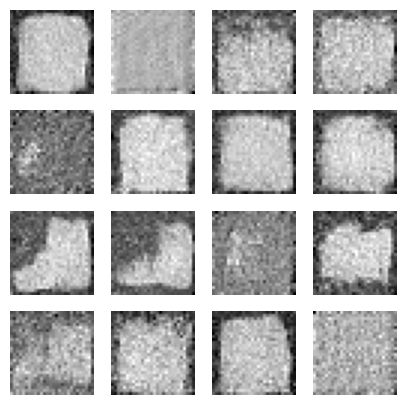

In [64]:
n_epochs = 1
log_idx = 100

idx = 0
unet.train()
losses = []
for epochs in range(n_epochs):
    for data in tqdm(train_loader):
        imgs = data.to(device)
        noisy_imgs, t, noise = get_noisy_imgs_t(imgs, betas, device=device)
        time = sin_times[t].to(device)
        optimizer.zero_grad()
        pred_noise = unet(noisy_imgs.to(torch.float32).to(device), time)
        # pred_noise = unet(noisy_imgs.to(torch.float32).to(device), t.to(device).long())

        loss = mse(pred_noise, noise)

        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        # idx+=1
        # if idx%log_idx == 0:
    print(np.mean(losses))
    losses = []
    plot_grid(sample_ddim(unet))



100%|██████████| 1000/1000 [00:28<00:00, 34.49it/s]


tensor(196.9876, device='cuda:0') tensor(-230.8437, device='cuda:0')


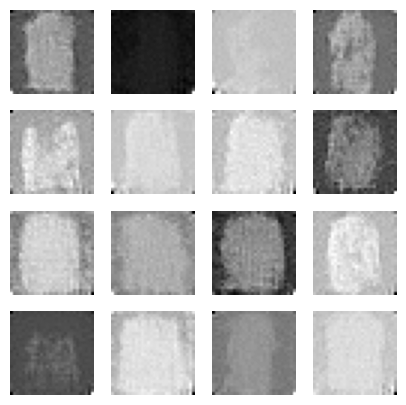

In [ ]:
x = imgs[700]
# x = (x + 1)/2

print(torch.max(x), torch.min(x))
# plt.plot(x.flatten().detach().cpu().numpy())
plt.imshow(x.detach().cpu()[0].permute(1,2,0).numpy())
plt.show()

In [ ]:
# for data in tqdm(train_loader):
  ## for data in tqdm(train_loader):
  #   imgs = data.to(device)
  #   noisy_imgs, t, noise = get_noisy_imgs_t(imgs, betas, device=device)
  #   time = sin_times[t].to(device)
  ## plt.imshow(data[0][0])
  #   break
